In [1]:
import shapely
from shapely.geometry import shape
import fiona
import pandas

# Data:
# http://download.geofabrik.de/europe/czech-republic-latest-free.shp.zip
# - gis.osm_landuse*
# - gis.osm_natural*

In [2]:
landuse = fiona.open('gis.osm_landuse_a_free_1.shp', 'r')

In [3]:
parks = []
for area in landuse:
    if area['properties']['fclass'] == 'park':
        parks.append(area)
len(parks)

8499

In [4]:
import collections
freq = collections.Counter(shape['properties']['fclass'] for shape in landuse)

In [5]:
freq

Counter({'allotments': 5269,
         'cemetery': 3699,
         'commercial': 481,
         'farm': 273403,
         'forest': 104815,
         'grass': 16769,
         'heath': 413,
         'industrial': 8258,
         'meadow': 299330,
         'military': 184,
         'nature_reserve': 2426,
         'orchard': 12698,
         'park': 8499,
         'quarry': 897,
         'recreation_ground': 1502,
         'residential': 32177,
         'retail': 339,
         'scrub': 28999,
         'vineyard': 10073})

In [6]:
parks[0]

{'geometry': {'coordinates': [[(16.5285284, 49.1767367),
    (16.5285715, 49.1767743),
    (16.5288373, 49.1766404),
    (16.5287183, 49.1765624),
    (16.5285284, 49.1767367)]],
  'type': 'Polygon'},
 'id': '0',
 'properties': OrderedDict([('osm_id', '4072815'),
              ('code', 7202),
              ('fclass', 'park'),
              ('name', None)]),
 'type': 'Feature'}

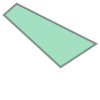

In [7]:
shape(parks[0]['geometry'])

In [9]:
teplarny = pandas.read_csv('teplarny-adresace.csv', sep=';')
teplarny = teplarny[teplarny['GPS lon'] < 18]  # odfiltrování Ostrava/Karviná

In [10]:
lat = teplarny['GPS lat']
lon = teplarny['GPS lon']

In [11]:
def get_min_max(series):
    minimum = series.min()
    maximum = series.max()
    diff = maximum - minimum
    return minimum - .1*diff, maximum + .1*diff

In [12]:
lat_min, lat_max = get_min_max(lat)
lon_min, lon_max = get_min_max(lon)

In [13]:
lat_min, lat_max, lon_min, lon_max

(49.116746390000003, 49.261869709999999, 16.48231461, 16.70996289)

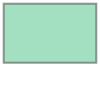

In [14]:
brno = shapely.geometry.box(lon_min, lat_min, lon_max, lat_max)
brno

In [15]:
areas = []
for area in landuse:
    coords = area['geometry']['coordinates'][0][0]
    try:
        lon, lat = area['geometry']['coordinates'][0][0]
        if not (lat_min < lat < lat_max and lon_min < lon < lon_max):
            continue
    except ValueError:
        pass # ??
    area = dict(area)
    area['shape'] = shp = shape(area['geometry'])
    if shp.intersects(brno):
        areas.append(area)                     


In [16]:
len(areas)

3890

In [17]:
areas[0]

{'geometry': {'coordinates': [[(16.5285284, 49.1767367),
    (16.5285715, 49.1767743),
    (16.5288373, 49.1766404),
    (16.5287183, 49.1765624),
    (16.5285284, 49.1767367)]],
  'type': 'Polygon'},
 'id': '0',
 'properties': OrderedDict([('osm_id', '4072815'),
              ('code', 7202),
              ('fclass', 'park'),
              ('name', None)]),
 'shape': <shapely.geometry.polygon.Polygon at 0x7f85ceae1940>,
 'type': 'Feature'}

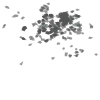

In [18]:
parks = areas[0]['shape']
for area in areas:
    if area['properties']['fclass'] == 'park':
        parks = parks.union(area['shape'])
parks

In [19]:
center = (lat_min+lat_max)/2, (lon_min+lon_max)/2
center

(49.189308050000001, 16.596138750000001)

1.097015674317727
Buf area 0.07841371226363546
Nonpark area 0.06166448468983797
Park area 0.01674922757379748


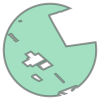

In [20]:
#qpoint = shapely.geometry.point.Point(*center)
# qpoint = shapely.geometry.point.Point(16.5572753, 49.2192439)  # Absolonova 26
# qpoint = shapely.geometry.point.Point(16.5559986, 49.221439)  # Absolonova 93
qpoint = shapely.geometry.point.Point(16.60475003, 49.2038422)  # Cihlářská 15a
print(qpoint.distance(parks) * 1000)
buf = qpoint.buffer(0.005)
print('Buf area', buf.area * 1000)
nonparks = buf.difference(parks)
print('Nonpark area', nonparks.area * 1000)
print('Park area', (buf.area - nonparks.area) * 1000)
nonparks


In [21]:
unions = {}
for area in areas:
    fclass = area['properties']['fclass']
    if fclass in unions:
        unions[fclass] = unions[fclass].union(area['shape'])
    else:
        unions[fclass] = area['shape']
unions

{'allotments': <shapely.geometry.multipolygon.MultiPolygon at 0x7f85cd852470>,
 'cemetery': <shapely.geometry.multipolygon.MultiPolygon at 0x7f85ceae1668>,
 'commercial': <shapely.geometry.multipolygon.MultiPolygon at 0x7f85cd852748>,
 'farm': <shapely.geometry.multipolygon.MultiPolygon at 0x7f85cd852320>,
 'forest': <shapely.geometry.multipolygon.MultiPolygon at 0x7f85cd852550>,
 'grass': <shapely.geometry.multipolygon.MultiPolygon at 0x7f85cd8527f0>,
 'heath': <shapely.geometry.multipolygon.MultiPolygon at 0x7f85cd852828>,
 'industrial': <shapely.geometry.multipolygon.MultiPolygon at 0x7f85cd852588>,
 'meadow': <shapely.geometry.multipolygon.MultiPolygon at 0x7f85cd8524e0>,
 'military': <shapely.geometry.multipolygon.MultiPolygon at 0x7f85cd8525c0>,
 'nature_reserve': <shapely.geometry.multipolygon.MultiPolygon at 0x7f85cd852630>,
 'orchard': <shapely.geometry.multipolygon.MultiPolygon at 0x7f85ceae1588>,
 'park': <shapely.geometry.multipolygon.MultiPolygon at 0x7f85cd852710>,
 'quar

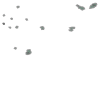

In [35]:
unions['quarry']